In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
crsp_data = pd.read_csv("crsp_data_new.csv",parse_dates=['date'],low_memory=False)

In [4]:
crsp_data.head()

,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,DLRETX,DLRET,PRC,RET,SHROUT,RETX
0,10000,1986-01-31,10,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,NaN,NaN,-4.37500,C,3680,C
1,10000,1986-02-28,10,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,NaN,NaN,-3.25000,-0.257143,3680,-0.257143
2,10000,1986-03-31,10,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,NaN,NaN,-4.43750,0.365385,3680,0.365385
3,10000,1986-04-30,10,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,NaN,NaN,-4.00000,-0.098592,3793,-0.098592
4,10000,1986-05-30,10,3990,OMFGA,OPTIMUM MANUFACTURING INC,7952,68391610,NaN,NaN,-3.10938,-0.222656,3793,-0.222656


In [6]:
crsp_data.groupby('CUSIP').apply(lambda x: x.PERMNO.nunique()).describe()

count    24018
mean         1
std          0
min          1
25%          1
50%          1
75%          1
max          1
dtype: float64

In [7]:
crsp_data['year'] = crsp_data.date.dt.year
crsp_data['month'] = crsp_data.date.dt.month

In [8]:
crsp_data['PRC'] = crsp_data.PRC.abs()
crsp_data['DLRET'] = pd.to_numeric(crsp_data.DLRET,errors='coerce')
crsp_data['RET'] = pd.to_numeric(crsp_data.RET, errors = 'coerce')
crsp_data['DLRETX'] = pd.to_numeric(crsp_data.DLRETX,errors='coerce')
crsp_data['RETX'] = pd.to_numeric(crsp_data.RETX, errors = 'coerce')
crsp_data.ix[crsp_data.DLRET.notnull(),'RET'] = crsp_data.ix[crsp_data.DLRET.notnull(),'DLRET']
crsp_data.ix[crsp_data.DLRETX.notnull(),'RETX'] = crsp_data.ix[crsp_data.DLRETX.notnull(),'DLRETX']
crsp_data.dropna(subset = ['RET'],inplace=True)

In [9]:
crsp_data.isnull().sum()

PERMNO          0
date            0
SHRCD           0
SICCD           0
TICKER     167315
COMNAM          0
PERMCO          0
CUSIP           0
DLRETX    3132266
DLRET     3132266
PRC         17623
RET             0
SHROUT          0
RETX            0
year            0
month           0
dtype: int64

In [30]:
ret_data = crsp_data.ix[:,['PERMNO','date','RET']]
ret_data.set_index(['date'],inplace=True)
ret_data.head(2)

,PERMNO,RET
date,,
1986-02-28,10000,-0.257143
1986-03-31,10000,0.365385


In [31]:
ret_data = ret_data.groupby('PERMNO').resample('BM').reset_index().sort_values(by = ['PERMNO','date'])

In [32]:
ret_data['l_mon_ret'] = ret_data.groupby(['PERMNO'])['RET'].apply(pd.rolling_apply, 11,
                                                                           (lambda x:((1+x).prod())-1), 11)

In [33]:
ret_data = ret_data.sort_values(by = ['PERMNO','date'])
ret_data['l_mon_ret'] = ret_data.groupby(['PERMNO'])['l_mon_ret'].shift(2)

In [34]:
not_avai_data = ret_data.groupby(ret_data.date.dt.year).apply(lambda x: 100*(x.isnull().sum()/len(x.isnull())))

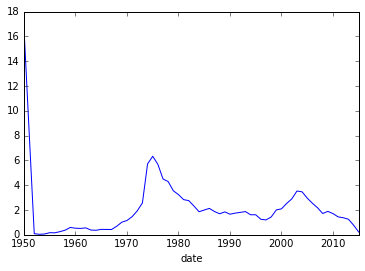

In [35]:
not_avai_data.RET.plot()

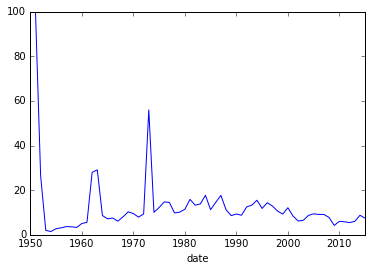

In [36]:
not_avai_data.l_mon_ret.plot()

In [37]:
ret_data['year'] = ret_data.date.dt.year
ret_data['month'] = ret_data.date.dt.month

In [38]:
crsp_data['market_cap'] = (crsp_data['SHROUT'] * crsp_data['PRC'])/1000 

In [39]:
ret_data = pd.merge(ret_data, crsp_data[['PERMNO','year','month','market_cap']], on = ['PERMNO','year','month'], how = 'left')
ret_data = ret_data.sort_values(by = ['PERMNO','year','month'])
ret_data['l_mcap'] = ret_data.groupby(['PERMNO'])['market_cap'].shift(1)
ret_data.drop(['RET','market_cap'],axis = 1,inplace=True)

In [40]:
crsp_data =pd.merge(crsp_data, ret_data[['PERMNO','year','month','l_mon_ret','l_mcap']], on=['PERMNO','year','month'], how ='left')

In [41]:
crsp_data.dropna(subset=['l_mon_ret','l_mcap'], how ='any',inplace=True)

In [42]:
crsp_data['Size_rank'] = crsp_data[['year','month','l_mcap']].groupby(['year','month']).rank(pct=True)['l_mcap']
crsp_data['Size'] = np.where(crsp_data['Size_rank'] > 0.8, "Big",'Small')

In [43]:
crsp_data['Mom_rank'] = crsp_data[['year','month','Size',
                                   'l_mon_ret']].groupby(['year','month','Size']).rank(pct = True)['l_mon_ret']
crsp_data['PR1YR']  = np.nan
crsp_data.ix[crsp_data.Mom_rank < 0.30,'PR1YR'] = "Down"
crsp_data.ix[crsp_data.Mom_rank > 0.70,'PR1YR'] = "Up"
crsp_data.ix[np.logical_and(crsp_data.Mom_rank <= 0.70,
                            crsp_data.Mom_rank >= 0.30) ,'PR1YR'] = 'Medium'

In [44]:
crsp_data['port_weights'] = crsp_data[['year','month','Size','PR1YR','l_mcap']].\
                            groupby(['year','month','Size','PR1YR'],group_keys = False).\
                            apply(lambda x: (x['l_mcap'])/(x['l_mcap'].sum()))

In [45]:
penul_data = crsp_data.groupby(['year','month','Size',
                          'PR1YR'])[['RET','port_weights']].apply(lambda g:np.average(g['RET'], weights=g['port_weights']))

In [46]:
penul_data = penul_data.unstack('Size').unstack('PR1YR').reset_index().sort_values(by=['year','month'])
penul_data.columns = [' '.join(col).strip() for col in penul_data.columns.values]

In [47]:
penul_data['MOM'] = (0.5*(penul_data['Big Up'] + penul_data['Small Up']) - 0.5*(penul_data['Big Down'] + penul_data['Small Down']))

In [48]:
penul_data[penul_data.year>=1970].to_csv("Mom.csv")